In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
data = pd.read_csv('EuropeCovid2_data.csv', index_col=0)

In [5]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


# 2. EDA

In [6]:
data['id'].value_counts()

AT    180
BE    180
DK    180
FR    180
DE    180
IT    180
NO    180
ES    180
SE    180
CH    180
GB    180
Name: id, dtype: int64

In [7]:
region = 'GB'
data_r = data[data.id == region]
Y_raw = data_r.deaths.to_numpy()
POI = np.cumsum(Y_raw) > 0

In [8]:
# Y 
Y_data = Y_raw[POI]
I_data = data_r.cases[POI].to_numpy()

In [9]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

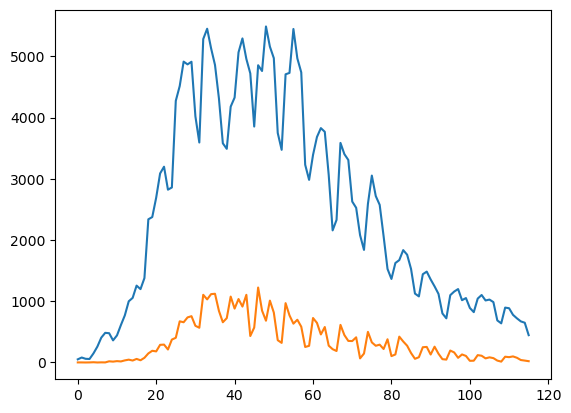

In [10]:
plt.plot(alpha*I_data)
plt.plot(Y_data)

In [11]:
GPi = np.load('EuropeCovid2_GPi.npz')

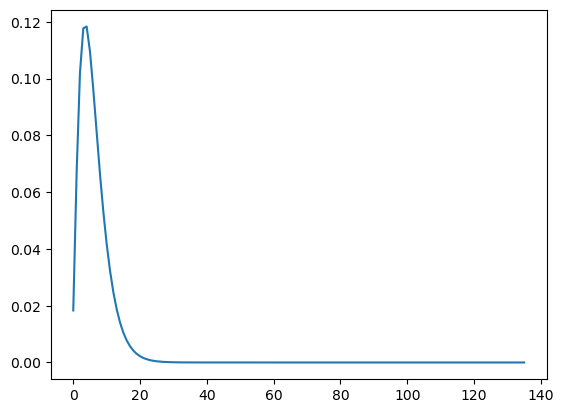

In [12]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

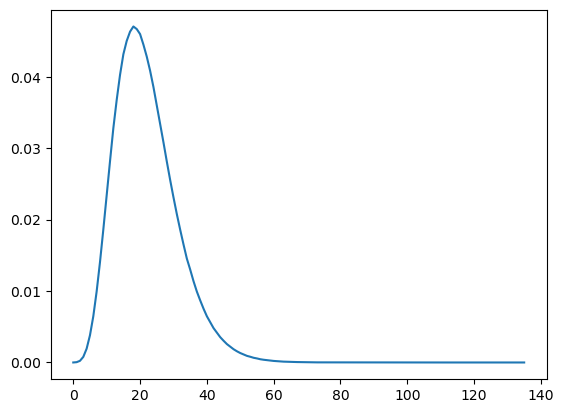

In [13]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [14]:
# A
d = 2
A = np.zeros([T+T0, d])

In [15]:
A[:,0] = np.full(T+T0, 1)
A[T0:,1] = data_r.lockdown[POI].to_numpy()

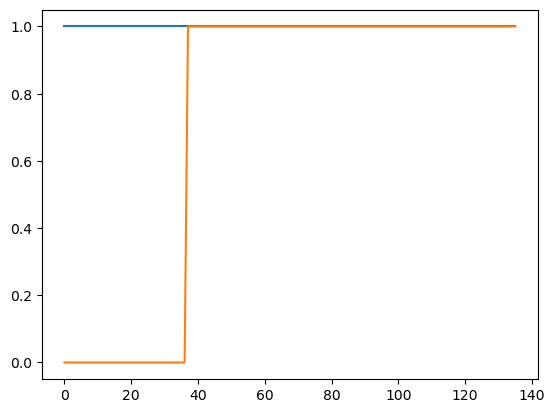

In [16]:
plt.plot(A)

# 3. fit by EM algorithm

In [17]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    ss=np.inf
    
    # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi_inv_ImG[:,0]) / np.sum((Pi_inv_ImG[:,0])**2)
        # mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = mhat_0 * Pi_inv_ImG[:,0]
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([ss, step_size/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [386]:
mmle_0 = 17.4
smle_eps = 138.5
bmle = [0.207, 1.872]

In [387]:
mhs_0, shs_eps, bhs =\
    fit(Y_data, mmle_0, smle_eps, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=0.05)

Before EM, shat_eps: 138.537564
1-th iteration finished, shat_eps: 139.963899, lapse: 0.003sec.
2-th iteration finished, shat_eps: 138.536794, lapse: 0.003sec.
3-th iteration finished, shat_eps: 138.527555, lapse: 0.002sec.
4-th iteration finished, shat_eps: 138.527540, lapse: 0.002sec.
5-th iteration finished, shat_eps: 138.527539, lapse: 0.004sec.
6-th iteration finished, shat_eps: 138.527539, lapse: 0.004sec.
7-th iteration finished, shat_eps: 138.527539, lapse: 0.004sec.
8-th iteration finished, shat_eps: 138.527539, lapse: 0.004sec.
9-th iteration finished, shat_eps: 138.527539, lapse: 0.006sec.
10-th iteration finished, shat_eps: 138.527539, lapse: 0.003sec.
11-th iteration finished, shat_eps: 138.527539, lapse: 0.003sec.
12-th iteration finished, shat_eps: 138.527539, lapse: 0.004sec.
13-th iteration finished, shat_eps: 138.527539, lapse: 0.003sec.
14-th iteration finished, shat_eps: 138.527539, lapse: 0.004sec.
15-th iteration finished, shat_eps: 138.527539, lapse: 0.002sec.
16

140-th iteration finished, shat_eps: 138.527534, lapse: 0.006sec.
141-th iteration finished, shat_eps: 138.527534, lapse: 0.007sec.
142-th iteration finished, shat_eps: 138.527534, lapse: 0.007sec.
143-th iteration finished, shat_eps: 138.527534, lapse: 0.003sec.
144-th iteration finished, shat_eps: 138.527534, lapse: 0.010sec.
145-th iteration finished, shat_eps: 138.527534, lapse: 0.010sec.
146-th iteration finished, shat_eps: 138.527534, lapse: 0.003sec.
147-th iteration finished, shat_eps: 138.527534, lapse: 0.006sec.
148-th iteration finished, shat_eps: 138.527534, lapse: 0.003sec.
149-th iteration finished, shat_eps: 138.527534, lapse: 0.005sec.
150-th iteration finished, shat_eps: 138.527533, lapse: 0.009sec.
151-th iteration finished, shat_eps: 138.527533, lapse: 0.009sec.
152-th iteration finished, shat_eps: 138.527533, lapse: 0.003sec.
153-th iteration finished, shat_eps: 138.527533, lapse: 0.007sec.
154-th iteration finished, shat_eps: 138.527533, lapse: 0.004sec.
155-th ite

266-th iteration finished, shat_eps: 138.527530, lapse: 0.009sec.
267-th iteration finished, shat_eps: 138.527530, lapse: 0.009sec.
268-th iteration finished, shat_eps: 138.527530, lapse: 0.006sec.
269-th iteration finished, shat_eps: 138.527530, lapse: 0.004sec.
270-th iteration finished, shat_eps: 138.527530, lapse: 0.004sec.
271-th iteration finished, shat_eps: 138.527530, lapse: 0.003sec.
272-th iteration finished, shat_eps: 138.527530, lapse: 0.004sec.
273-th iteration finished, shat_eps: 138.527530, lapse: 0.003sec.
274-th iteration finished, shat_eps: 138.527530, lapse: 0.003sec.
275-th iteration finished, shat_eps: 138.527530, lapse: 0.003sec.
276-th iteration finished, shat_eps: 138.527530, lapse: 0.003sec.
277-th iteration finished, shat_eps: 138.527530, lapse: 0.003sec.
278-th iteration finished, shat_eps: 138.527530, lapse: 0.008sec.
279-th iteration finished, shat_eps: 138.527530, lapse: 0.007sec.
280-th iteration finished, shat_eps: 138.527530, lapse: 0.004sec.
281-th ite

398-th iteration finished, shat_eps: 138.527527, lapse: 0.006sec.
399-th iteration finished, shat_eps: 138.527527, lapse: 0.004sec.
400-th iteration finished, shat_eps: 138.527527, lapse: 0.006sec.
401-th iteration finished, shat_eps: 138.527527, lapse: 0.004sec.
402-th iteration finished, shat_eps: 138.527527, lapse: 0.008sec.
403-th iteration finished, shat_eps: 138.527527, lapse: 0.005sec.
404-th iteration finished, shat_eps: 138.527527, lapse: 0.005sec.
405-th iteration finished, shat_eps: 138.527527, lapse: 0.004sec.
406-th iteration finished, shat_eps: 138.527527, lapse: 0.003sec.
407-th iteration finished, shat_eps: 138.527527, lapse: 0.008sec.
408-th iteration finished, shat_eps: 138.527527, lapse: 0.004sec.
409-th iteration finished, shat_eps: 138.527527, lapse: 0.003sec.
410-th iteration finished, shat_eps: 138.527527, lapse: 0.006sec.
411-th iteration finished, shat_eps: 138.527527, lapse: 0.003sec.
412-th iteration finished, shat_eps: 138.527527, lapse: 0.005sec.
413-th ite

532-th iteration finished, shat_eps: 138.527525, lapse: 0.031sec.
533-th iteration finished, shat_eps: 138.527525, lapse: 0.012sec.
534-th iteration finished, shat_eps: 138.527525, lapse: 0.009sec.
535-th iteration finished, shat_eps: 138.527525, lapse: 0.011sec.
536-th iteration finished, shat_eps: 138.527525, lapse: 0.005sec.
537-th iteration finished, shat_eps: 138.527525, lapse: 0.018sec.
538-th iteration finished, shat_eps: 138.527525, lapse: 0.017sec.
539-th iteration finished, shat_eps: 138.527525, lapse: 0.003sec.
540-th iteration finished, shat_eps: 138.527525, lapse: 0.052sec.
541-th iteration finished, shat_eps: 138.527525, lapse: 0.006sec.
542-th iteration finished, shat_eps: 138.527525, lapse: 0.017sec.
543-th iteration finished, shat_eps: 138.527525, lapse: 0.003sec.
544-th iteration finished, shat_eps: 138.527525, lapse: 0.010sec.
545-th iteration finished, shat_eps: 138.527525, lapse: 0.003sec.
546-th iteration finished, shat_eps: 138.527525, lapse: 0.008sec.
547-th ite

679-th iteration finished, shat_eps: 138.527523, lapse: 0.005sec.
680-th iteration finished, shat_eps: 138.527523, lapse: 0.006sec.
681-th iteration finished, shat_eps: 138.527523, lapse: 0.007sec.
682-th iteration finished, shat_eps: 138.527523, lapse: 0.004sec.
683-th iteration finished, shat_eps: 138.527523, lapse: 0.003sec.
684-th iteration finished, shat_eps: 138.527523, lapse: 0.004sec.
685-th iteration finished, shat_eps: 138.527523, lapse: 0.004sec.
686-th iteration finished, shat_eps: 138.527523, lapse: 0.005sec.
687-th iteration finished, shat_eps: 138.527523, lapse: 0.004sec.
688-th iteration finished, shat_eps: 138.527523, lapse: 0.004sec.
689-th iteration finished, shat_eps: 138.527523, lapse: 0.009sec.
690-th iteration finished, shat_eps: 138.527523, lapse: 0.005sec.
691-th iteration finished, shat_eps: 138.527523, lapse: 0.008sec.
692-th iteration finished, shat_eps: 138.527523, lapse: 0.005sec.
693-th iteration finished, shat_eps: 138.527523, lapse: 0.003sec.
694-th ite

809-th iteration finished, shat_eps: 138.527522, lapse: 0.004sec.
810-th iteration finished, shat_eps: 138.527522, lapse: 0.005sec.
811-th iteration finished, shat_eps: 138.527522, lapse: 0.004sec.
812-th iteration finished, shat_eps: 138.527522, lapse: 0.005sec.
813-th iteration finished, shat_eps: 138.527522, lapse: 0.007sec.
814-th iteration finished, shat_eps: 138.527522, lapse: 0.010sec.
815-th iteration finished, shat_eps: 138.527522, lapse: 0.006sec.
816-th iteration finished, shat_eps: 138.527522, lapse: 0.003sec.
817-th iteration finished, shat_eps: 138.527522, lapse: 0.005sec.
818-th iteration finished, shat_eps: 138.527522, lapse: 0.005sec.
819-th iteration finished, shat_eps: 138.527522, lapse: 0.006sec.
820-th iteration finished, shat_eps: 138.527522, lapse: 0.003sec.
821-th iteration finished, shat_eps: 138.527522, lapse: 0.004sec.
822-th iteration finished, shat_eps: 138.527522, lapse: 0.004sec.
823-th iteration finished, shat_eps: 138.527522, lapse: 0.004sec.
824-th ite

937-th iteration finished, shat_eps: 138.527521, lapse: 0.006sec.
938-th iteration finished, shat_eps: 138.527521, lapse: 0.016sec.
939-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
940-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
941-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
942-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
943-th iteration finished, shat_eps: 138.527521, lapse: 0.005sec.
944-th iteration finished, shat_eps: 138.527521, lapse: 0.005sec.
945-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
946-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
947-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
948-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
949-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
950-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
951-th iteration finished, shat_eps: 138.527521, lapse: 0.006sec.
952-th ite

1078-th iteration finished, shat_eps: 138.527521, lapse: 0.005sec.
1079-th iteration finished, shat_eps: 138.527521, lapse: 0.009sec.
1080-th iteration finished, shat_eps: 138.527521, lapse: 0.006sec.
1081-th iteration finished, shat_eps: 138.527521, lapse: 0.005sec.
1082-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
1083-th iteration finished, shat_eps: 138.527521, lapse: 0.003sec.
1084-th iteration finished, shat_eps: 138.527521, lapse: 0.007sec.
1085-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
1086-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
1087-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
1088-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
1089-th iteration finished, shat_eps: 138.527521, lapse: 0.005sec.
1090-th iteration finished, shat_eps: 138.527521, lapse: 0.004sec.
1091-th iteration finished, shat_eps: 138.527521, lapse: 0.007sec.
1092-th iteration finished, shat_eps: 138.527521, lapse: 0.003

1207-th iteration finished, shat_eps: 138.527520, lapse: 0.010sec.
1208-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1209-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1210-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1211-th iteration finished, shat_eps: 138.527520, lapse: 0.060sec.
1212-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1213-th iteration finished, shat_eps: 138.527520, lapse: 0.006sec.
1214-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1215-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1216-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1217-th iteration finished, shat_eps: 138.527520, lapse: 0.006sec.
1218-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1219-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1220-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1221-th iteration finished, shat_eps: 138.527520, lapse: 0.005

1364-th iteration finished, shat_eps: 138.527520, lapse: 0.012sec.
1365-th iteration finished, shat_eps: 138.527520, lapse: 0.011sec.
1366-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1367-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1368-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1369-th iteration finished, shat_eps: 138.527520, lapse: 0.006sec.
1370-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1371-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1372-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1373-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1374-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1375-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1376-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1377-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1378-th iteration finished, shat_eps: 138.527520, lapse: 0.005

1497-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1498-th iteration finished, shat_eps: 138.527520, lapse: 0.008sec.
1499-th iteration finished, shat_eps: 138.527520, lapse: 0.006sec.
1500-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1501-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1502-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1503-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1504-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1505-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1506-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1507-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1508-th iteration finished, shat_eps: 138.527520, lapse: 0.012sec.
1509-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1510-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1511-th iteration finished, shat_eps: 138.527520, lapse: 0.003

1637-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1638-th iteration finished, shat_eps: 138.527520, lapse: 0.006sec.
1639-th iteration finished, shat_eps: 138.527520, lapse: 0.004sec.
1640-th iteration finished, shat_eps: 138.527520, lapse: 0.007sec.
1641-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1642-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1643-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1644-th iteration finished, shat_eps: 138.527520, lapse: 0.006sec.
1645-th iteration finished, shat_eps: 138.527520, lapse: 0.006sec.
1646-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1647-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1648-th iteration finished, shat_eps: 138.527520, lapse: 0.003sec.
1649-th iteration finished, shat_eps: 138.527520, lapse: 0.005sec.
1650-th iteration finished, shat_eps: 138.527520, lapse: 0.009sec.
1651-th iteration finished, shat_eps: 138.527520, lapse: 0.004

1789-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
1790-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
1791-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
1792-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
1793-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1794-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1795-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1796-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
1797-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
1798-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1799-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1800-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1801-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
1802-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
1803-th iteration finished, shat_eps: 138.527519, lapse: 0.005

1937-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
1938-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
1939-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
1940-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1941-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1942-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
1943-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
1944-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
1945-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
1946-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
1947-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
1948-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
1949-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1950-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
1951-th iteration finished, shat_eps: 138.527519, lapse: 0.004

2075-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2076-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
2077-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2078-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2079-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
2080-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2081-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
2082-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
2083-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2084-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
2085-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2086-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2087-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2088-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
2089-th iteration finished, shat_eps: 138.527519, lapse: 0.004

2217-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
2218-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2219-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2220-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
2221-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2222-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2223-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2224-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
2225-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2226-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2227-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2228-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2229-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2230-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2231-th iteration finished, shat_eps: 138.527519, lapse: 0.003

2371-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
2372-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
2373-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2374-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2375-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2376-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2377-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
2378-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2379-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2380-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2381-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2382-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2383-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2384-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2385-th iteration finished, shat_eps: 138.527519, lapse: 0.004

2514-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
2515-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
2516-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2517-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2518-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2519-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2520-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2521-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2522-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2523-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2524-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2525-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2526-th iteration finished, shat_eps: 138.527519, lapse: 0.022sec.
2527-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2528-th iteration finished, shat_eps: 138.527519, lapse: 0.003

2665-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
2666-th iteration finished, shat_eps: 138.527519, lapse: 0.013sec.
2667-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
2668-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2669-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
2670-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2671-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2672-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2673-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2674-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2675-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2676-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2677-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2678-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2679-th iteration finished, shat_eps: 138.527519, lapse: 0.004

2815-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2816-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2817-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2818-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2819-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2820-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2821-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
2822-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2823-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2824-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2825-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2826-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
2827-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2828-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2829-th iteration finished, shat_eps: 138.527519, lapse: 0.004

2971-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2972-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2973-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
2974-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2975-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2976-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2977-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2978-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2979-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2980-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2981-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
2982-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2983-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
2984-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
2985-th iteration finished, shat_eps: 138.527519, lapse: 0.003

3118-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3119-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3120-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
3121-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3122-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3123-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3124-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3125-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3126-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3127-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3128-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3129-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3130-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
3131-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3132-th iteration finished, shat_eps: 138.527519, lapse: 0.007

3258-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
3259-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
3260-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3261-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3262-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3263-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3264-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3265-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3266-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3267-th iteration finished, shat_eps: 138.527519, lapse: 0.019sec.
3268-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3269-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3270-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
3271-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3272-th iteration finished, shat_eps: 138.527519, lapse: 0.006

3391-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3392-th iteration finished, shat_eps: 138.527519, lapse: 0.014sec.
3393-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3394-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3395-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
3396-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
3397-th iteration finished, shat_eps: 138.527519, lapse: 0.014sec.
3398-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
3399-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3400-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
3401-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3402-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
3403-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3404-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3405-th iteration finished, shat_eps: 138.527519, lapse: 0.007

3533-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
3534-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3535-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
3536-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3537-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3538-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3539-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3540-th iteration finished, shat_eps: 138.527519, lapse: 0.016sec.
3541-th iteration finished, shat_eps: 138.527519, lapse: 0.015sec.
3542-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
3543-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3544-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3545-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3546-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3547-th iteration finished, shat_eps: 138.527519, lapse: 0.007

3664-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
3665-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
3666-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3667-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3668-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3669-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3670-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3671-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3672-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3673-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
3674-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3675-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
3676-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
3677-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3678-th iteration finished, shat_eps: 138.527519, lapse: 0.005

3811-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3812-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3813-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3814-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3815-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3816-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3817-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
3818-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3819-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3820-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3821-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3822-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3823-th iteration finished, shat_eps: 138.527519, lapse: 0.035sec.
3824-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3825-th iteration finished, shat_eps: 138.527519, lapse: 0.007

3940-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3941-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3942-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3943-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3944-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3945-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3946-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3947-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3948-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
3949-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
3950-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
3951-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
3952-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
3953-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
3954-th iteration finished, shat_eps: 138.527519, lapse: 0.003

4085-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4086-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4087-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4088-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4089-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4090-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4091-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4092-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4093-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4094-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4095-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4096-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4097-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4098-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4099-th iteration finished, shat_eps: 138.527519, lapse: 0.012

4225-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
4226-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4227-th iteration finished, shat_eps: 138.527519, lapse: 0.014sec.
4228-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4229-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4230-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
4231-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4232-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4233-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4234-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
4235-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
4236-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
4237-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4238-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4239-th iteration finished, shat_eps: 138.527519, lapse: 0.004

4376-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4377-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
4378-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4379-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4380-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4381-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4382-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4383-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4384-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
4385-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4386-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4387-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4388-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4389-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4390-th iteration finished, shat_eps: 138.527519, lapse: 0.003

4503-th iteration finished, shat_eps: 138.527519, lapse: 0.017sec.
4504-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4505-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4506-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4507-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
4508-th iteration finished, shat_eps: 138.527519, lapse: 0.044sec.
4509-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4510-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
4511-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4512-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
4513-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
4514-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4515-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
4516-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4517-th iteration finished, shat_eps: 138.527519, lapse: 0.005

4640-th iteration finished, shat_eps: 138.527519, lapse: 0.015sec.
4641-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4642-th iteration finished, shat_eps: 138.527519, lapse: 0.014sec.
4643-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
4644-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
4645-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
4646-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
4647-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
4648-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4649-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
4650-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4651-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4652-th iteration finished, shat_eps: 138.527519, lapse: 0.014sec.
4653-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
4654-th iteration finished, shat_eps: 138.527519, lapse: 0.008

4771-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4772-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
4773-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4774-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4775-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
4776-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
4777-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4778-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
4779-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4780-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
4781-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
4782-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4783-th iteration finished, shat_eps: 138.527519, lapse: 0.032sec.
4784-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
4785-th iteration finished, shat_eps: 138.527519, lapse: 0.010

4898-th iteration finished, shat_eps: 138.527519, lapse: 0.024sec.
4899-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4900-th iteration finished, shat_eps: 138.527519, lapse: 0.036sec.
4901-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4902-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
4903-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4904-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
4905-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4906-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
4907-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4908-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4909-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
4910-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
4911-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
4912-th iteration finished, shat_eps: 138.527519, lapse: 0.003

5034-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
5035-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
5036-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
5037-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5038-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5039-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5040-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5041-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
5042-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
5043-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5044-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
5045-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
5046-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5047-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5048-th iteration finished, shat_eps: 138.527519, lapse: 0.007

5175-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
5176-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
5177-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5178-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5179-th iteration finished, shat_eps: 138.527519, lapse: 0.021sec.
5180-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
5181-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5182-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5183-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5184-th iteration finished, shat_eps: 138.527519, lapse: 0.018sec.
5185-th iteration finished, shat_eps: 138.527519, lapse: 0.016sec.
5186-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5187-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5188-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
5189-th iteration finished, shat_eps: 138.527519, lapse: 0.004

5298-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5299-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5300-th iteration finished, shat_eps: 138.527519, lapse: 0.017sec.
5301-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
5302-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5303-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5304-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5305-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5306-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
5307-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5308-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
5309-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5310-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
5311-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5312-th iteration finished, shat_eps: 138.527519, lapse: 0.005

5440-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5441-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5442-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5443-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5444-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5445-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5446-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5447-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5448-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5449-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5450-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5451-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5452-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5453-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5454-th iteration finished, shat_eps: 138.527519, lapse: 0.003

5588-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5589-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5590-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
5591-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
5592-th iteration finished, shat_eps: 138.527519, lapse: 0.034sec.
5593-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
5594-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
5595-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5596-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5597-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
5598-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5599-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
5600-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5601-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5602-th iteration finished, shat_eps: 138.527519, lapse: 0.006

5726-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
5727-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5728-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5729-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
5730-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5731-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5732-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5733-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
5734-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5735-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5736-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
5737-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5738-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5739-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
5740-th iteration finished, shat_eps: 138.527519, lapse: 0.004

5855-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
5856-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5857-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
5858-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5859-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5860-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5861-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5862-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5863-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5864-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5865-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
5866-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
5867-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
5868-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
5869-th iteration finished, shat_eps: 138.527519, lapse: 0.003

6000-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6001-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6002-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6003-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6004-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6005-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6006-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6007-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6008-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6009-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6010-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6011-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6012-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
6013-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6014-th iteration finished, shat_eps: 138.527519, lapse: 0.005

6128-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6129-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6130-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6131-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6132-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6133-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6134-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6135-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6136-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6137-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6138-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6139-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6140-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6141-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6142-th iteration finished, shat_eps: 138.527519, lapse: 0.006

6258-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6259-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
6260-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6261-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6262-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6263-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6264-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6265-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6266-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6267-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
6268-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
6269-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6270-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6271-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6272-th iteration finished, shat_eps: 138.527519, lapse: 0.004

6396-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6397-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6398-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6399-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6400-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6401-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6402-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6403-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6404-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6405-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6406-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6407-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6408-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6409-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6410-th iteration finished, shat_eps: 138.527519, lapse: 0.004

6530-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6531-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
6532-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
6533-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6534-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6535-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6536-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6537-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6538-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6539-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6540-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6541-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
6542-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6543-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6544-th iteration finished, shat_eps: 138.527519, lapse: 0.003

6668-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6669-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6670-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6671-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6672-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6673-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6674-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6675-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6676-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
6677-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6678-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6679-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6680-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6681-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6682-th iteration finished, shat_eps: 138.527519, lapse: 0.007

6802-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6803-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6804-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6805-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6806-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6807-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6808-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6809-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6810-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6811-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6812-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6813-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6814-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
6815-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6816-th iteration finished, shat_eps: 138.527519, lapse: 0.004

6939-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6940-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6941-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
6942-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6943-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
6944-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6945-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6946-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
6947-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6948-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6949-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
6950-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6951-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6952-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
6953-th iteration finished, shat_eps: 138.527519, lapse: 0.004

7065-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7066-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
7067-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
7068-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7069-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7070-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7071-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7072-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7073-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
7074-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7075-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7076-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7077-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7078-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
7079-th iteration finished, shat_eps: 138.527519, lapse: 0.003

7204-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
7205-th iteration finished, shat_eps: 138.527519, lapse: 0.014sec.
7206-th iteration finished, shat_eps: 138.527519, lapse: 0.018sec.
7207-th iteration finished, shat_eps: 138.527519, lapse: 0.012sec.
7208-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7209-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7210-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
7211-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7212-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7213-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7214-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7215-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7216-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
7217-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
7218-th iteration finished, shat_eps: 138.527519, lapse: 0.005

7337-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7338-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7339-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
7340-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7341-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7342-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7343-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7344-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
7345-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7346-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
7347-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7348-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7349-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7350-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7351-th iteration finished, shat_eps: 138.527519, lapse: 0.004

7486-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7487-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
7488-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7489-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7490-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7491-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7492-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7493-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7494-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7495-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7496-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7497-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7498-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7499-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
7500-th iteration finished, shat_eps: 138.527519, lapse: 0.003

7638-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
7639-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
7640-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7641-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7642-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7643-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7644-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
7645-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7646-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7647-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7648-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7649-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7650-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7651-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7652-th iteration finished, shat_eps: 138.527519, lapse: 0.005

7796-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7797-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
7798-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7799-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7800-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7801-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7802-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7803-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7804-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7805-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
7806-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7807-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7808-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7809-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7810-th iteration finished, shat_eps: 138.527519, lapse: 0.004

7948-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7949-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
7950-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
7951-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
7952-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7953-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7954-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7955-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7956-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7957-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7958-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
7959-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
7960-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7961-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
7962-th iteration finished, shat_eps: 138.527519, lapse: 0.003

8089-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8090-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8091-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8092-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
8093-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8094-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8095-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8096-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8097-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8098-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8099-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8100-th iteration finished, shat_eps: 138.527519, lapse: 0.016sec.
8101-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8102-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8103-th iteration finished, shat_eps: 138.527519, lapse: 0.003

8231-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8232-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8233-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8234-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8235-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8236-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8237-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8238-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8239-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
8240-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
8241-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8242-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
8243-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8244-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8245-th iteration finished, shat_eps: 138.527519, lapse: 0.006

8379-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8380-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8381-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8382-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
8383-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8384-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8385-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8386-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8387-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8388-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8389-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8390-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8391-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8392-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8393-th iteration finished, shat_eps: 138.527519, lapse: 0.007

8530-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8531-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8532-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
8533-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8534-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8535-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8536-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8537-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8538-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8539-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8540-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
8541-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8542-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
8543-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8544-th iteration finished, shat_eps: 138.527519, lapse: 0.003

8677-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8678-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8679-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8680-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8681-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8682-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8683-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8684-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8685-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8686-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8687-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8688-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8689-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8690-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8691-th iteration finished, shat_eps: 138.527519, lapse: 0.004

8835-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8836-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8837-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
8838-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8839-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8840-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8841-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8842-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8843-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8844-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8845-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8846-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8847-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8848-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8849-th iteration finished, shat_eps: 138.527519, lapse: 0.004

8964-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8965-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
8966-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8967-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8968-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8969-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8970-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8971-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8972-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8973-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8974-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
8975-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8976-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
8977-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
8978-th iteration finished, shat_eps: 138.527519, lapse: 0.004

9099-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9100-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9101-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
9102-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9103-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9104-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9105-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9106-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9107-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9108-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9109-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9110-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9111-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9112-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9113-th iteration finished, shat_eps: 138.527519, lapse: 0.003

9254-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
9255-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
9256-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9257-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
9258-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9259-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9260-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
9261-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9262-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9263-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9264-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9265-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
9266-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9267-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
9268-th iteration finished, shat_eps: 138.527519, lapse: 0.004

9401-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9402-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9403-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
9404-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9405-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9406-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9407-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9408-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9409-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9410-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9411-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9412-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
9413-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9414-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9415-th iteration finished, shat_eps: 138.527519, lapse: 0.004

9556-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9557-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
9558-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
9559-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9560-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9561-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9562-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9563-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9564-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9565-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
9566-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9567-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9568-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9569-th iteration finished, shat_eps: 138.527519, lapse: 0.006sec.
9570-th iteration finished, shat_eps: 138.527519, lapse: 0.003

9703-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9704-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9705-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
9706-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9707-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9708-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9709-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9710-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9711-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9712-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9713-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9714-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9715-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9716-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9717-th iteration finished, shat_eps: 138.527519, lapse: 0.004

9852-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9853-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9854-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
9855-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9856-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9857-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9858-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9859-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9860-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9861-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9862-th iteration finished, shat_eps: 138.527519, lapse: 0.007sec.
9863-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9864-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9865-th iteration finished, shat_eps: 138.527519, lapse: 0.005sec.
9866-th iteration finished, shat_eps: 138.527519, lapse: 0.003

9989-th iteration finished, shat_eps: 138.527519, lapse: 0.009sec.
9990-th iteration finished, shat_eps: 138.527519, lapse: 0.011sec.
9991-th iteration finished, shat_eps: 138.527519, lapse: 0.008sec.
9992-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9993-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9994-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9995-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9996-th iteration finished, shat_eps: 138.527519, lapse: 0.010sec.
9997-th iteration finished, shat_eps: 138.527519, lapse: 0.003sec.
9998-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
9999-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.
10000-th iteration finished, shat_eps: 138.527519, lapse: 0.004sec.


In [348]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

In [349]:
mmle_0, smle_eps, bmle

(17.431878572939592, 138.52751909583705, array([0.20674329, 1.87164695]))

## plots

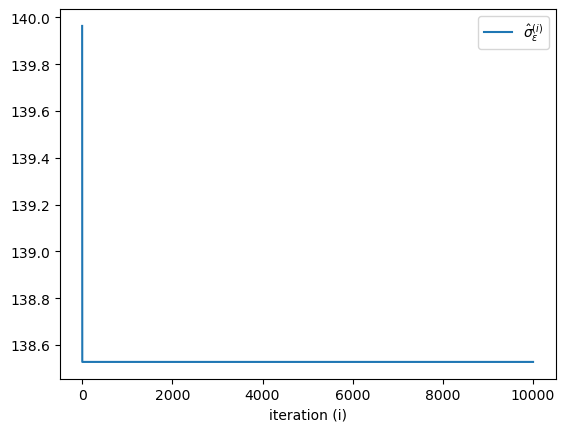

In [19]:
plt.plot(shs_eps, label=r"$\hat{\sigma}^{(i)}_\epsilon$")
plt.xlabel("iteration (i)"); plt.legend()

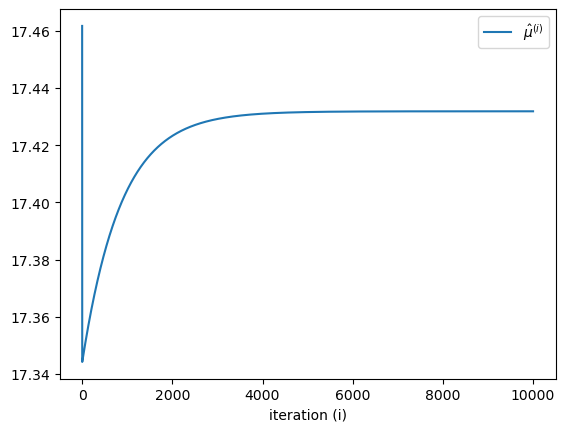

In [20]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

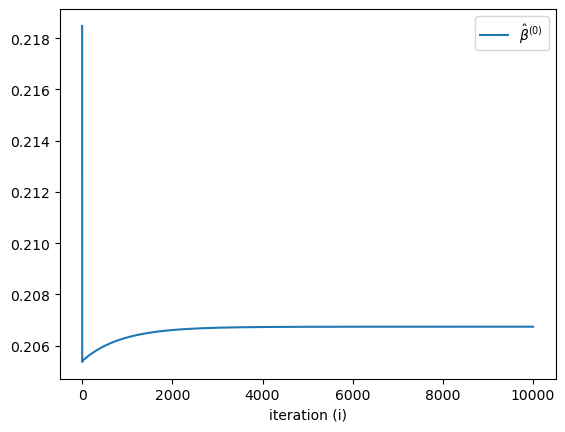

In [21]:
plt.plot(bhs[:,0], label=r"$\hat{\beta}^{(0)}$")
plt.xlabel("iteration (i)"); plt.legend()

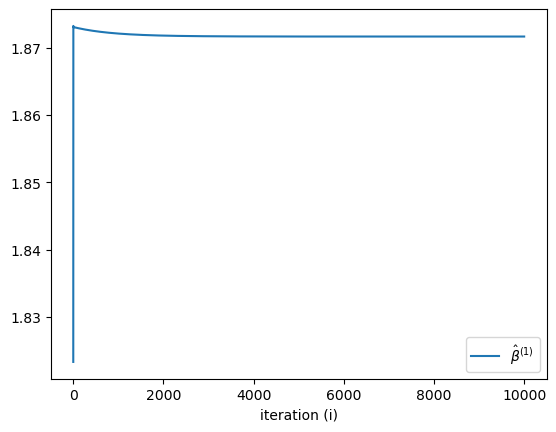

In [22]:
plt.plot(bhs[:,1], label=r"$\hat{\beta}^{(1)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Parametric bootstrap

In [23]:
num_sim = 1000
n_iter = 10000

In [24]:
msim_0 = np.zeros([num_sim, n_iter])
ssim_eps = np.zeros([num_sim, n_iter])
bsim = np.zeros([num_sim, n_iter, d])

In [25]:
I_sim = np.zeros(T+T0)
Ys_sim = np.zeros([num_sim, T])

## simulation

In [26]:
mu_0 = mmle_0
s_eps = smle_eps
beta = bmle

In [27]:
R = np.zeros(T+T0)
for t in np.arange(T+T0):
    R[t] = K / (1 + np.exp(beta @ A[t]))

In [28]:
I_sim[0] = mu_0
for t in np.arange(1, T0):
    I_sim[t] = R[t] * np.sum(np.flip(I_sim[:t])*g[:t])
for t in np.arange(T0,T+T0):
    I_sim[t] = R[t] * np.sum(np.flip(I_sim[:t])*g[:t])

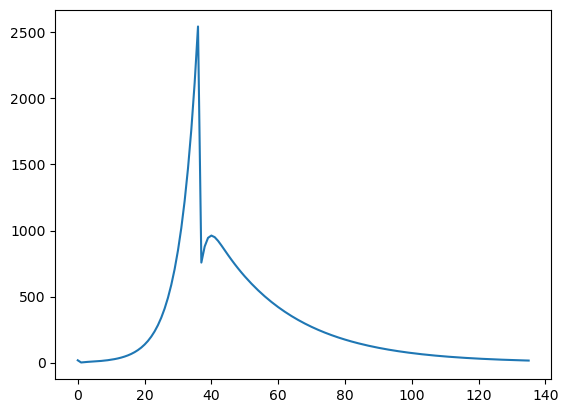

In [29]:
plt.plot(I_sim)

In [30]:
Y_sim = np.zeros([T])    
for t in np.arange(T):
    Y_sim[t] = alpha * np.sum(np.flip(I_sim[:t+T0])*pi[:t+T0]) + np.random.normal(0,s_eps)

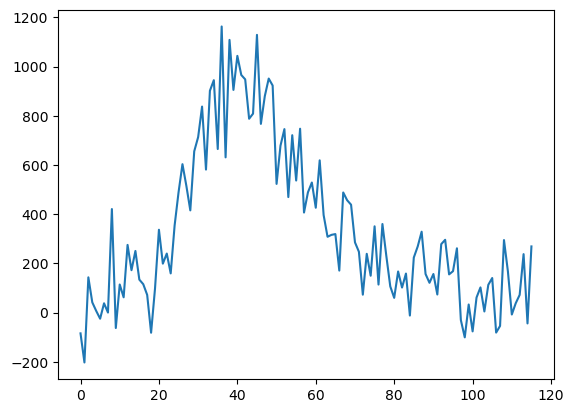

In [31]:
plt.plot(Y_sim)

In [369]:
mhat_0, shat_eps, bhat =\
    fit(Y_sim, minit_0 = mu_0, sinit_eps = s_eps,
        binit = beta, history=True, n_iter=n_iter, step_size=0.05) 

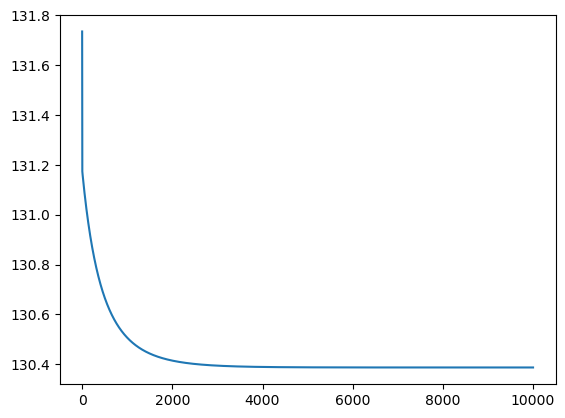

In [370]:
plt.plot(shat_eps)

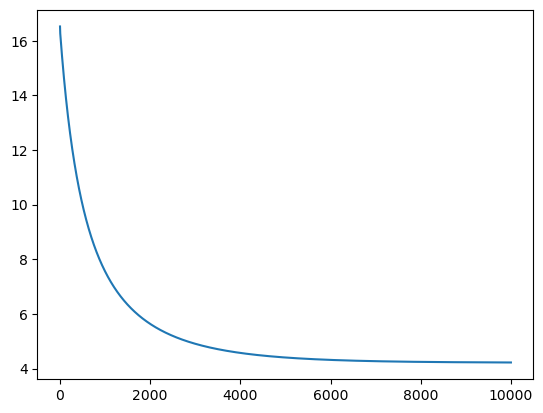

In [371]:
plt.plot(mhat_0)

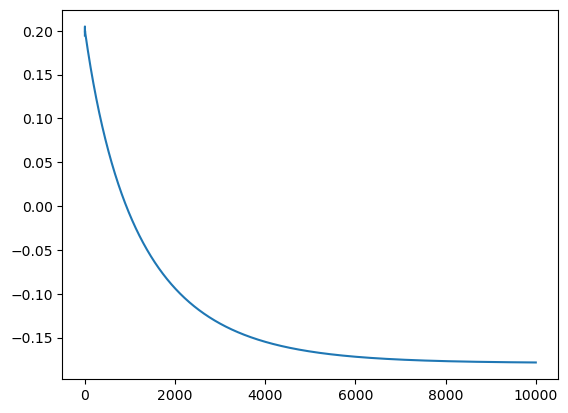

In [372]:
plt.plot(bhat[:,0])

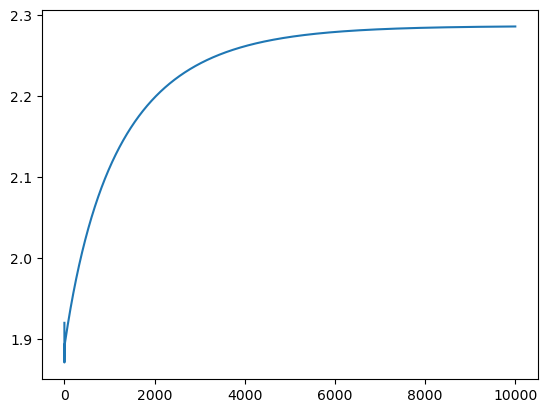

In [373]:
plt.plot(bhat[:,1])

## iteration

In [374]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    Y_sim = np.zeros([T])    
    for t in np.arange(T):
        Y_sim[t] = alpha * np.sum(np.flip(I_sim[:t+T0])*pi[:t+T0]) + np.random.normal(0,s_eps)
        
    mhat_0, shat_eps, bhat =\
        fit(Y_sim, minit_0 = mmle_0, sinit_eps = smle_eps,
            binit = bmle, history=True, n_iter=n_iter, step_size=0.05) 
    
    msim_0[iter_sim] = mhat_0
    ssim_eps[iter_sim] = shat_eps
    bsim[iter_sim] = bhat
    
    Ys_sim[iter_sim] = Y_sim
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 46.582798 sec.
2-th simulation finished, 46.374238 sec.
3-th simulation finished, 45.936330 sec.
4-th simulation finished, 33.883257 sec.
5-th simulation finished, 33.542953 sec.
6-th simulation finished, 34.657317 sec.
7-th simulation finished, 38.456513 sec.
8-th simulation finished, 34.619161 sec.
9-th simulation finished, 34.806333 sec.
10-th simulation finished, 32.243636 sec.
11-th simulation finished, 32.241175 sec.
12-th simulation finished, 32.293533 sec.
13-th simulation finished, 33.694348 sec.
14-th simulation finished, 34.046258 sec.
15-th simulation finished, 32.133928 sec.
16-th simulation finished, 32.440129 sec.
17-th simulation finished, 32.512286 sec.
18-th simulation finished, 33.667793 sec.
19-th simulation finished, 33.328845 sec.
20-th simulation finished, 32.199115 sec.
21-th simulation finished, 32.468565 sec.
22-th simulation finished, 34.336004 sec.
23-th simulation finished, 34.314483 sec.
24-th simulation finished, 33.144580 sec.
2

195-th simulation finished, 37.142383 sec.
196-th simulation finished, 39.809096 sec.
197-th simulation finished, 36.933100 sec.
198-th simulation finished, 39.258873 sec.
199-th simulation finished, 38.459607 sec.
200-th simulation finished, 37.977093 sec.
201-th simulation finished, 42.056075 sec.
202-th simulation finished, 38.244904 sec.
203-th simulation finished, 37.700587 sec.
204-th simulation finished, 42.557136 sec.
205-th simulation finished, 45.561349 sec.
206-th simulation finished, 43.361298 sec.
207-th simulation finished, 44.110811 sec.
208-th simulation finished, 42.228434 sec.
209-th simulation finished, 44.065278 sec.
210-th simulation finished, 43.227594 sec.
211-th simulation finished, 43.672930 sec.
212-th simulation finished, 41.918365 sec.
213-th simulation finished, 49.160460 sec.
214-th simulation finished, 42.765355 sec.
215-th simulation finished, 38.061394 sec.
216-th simulation finished, 39.287888 sec.
217-th simulation finished, 44.170392 sec.
218-th simu

386-th simulation finished, 50.261271 sec.
387-th simulation finished, 45.095451 sec.
388-th simulation finished, 37.534429 sec.
389-th simulation finished, 39.040697 sec.
390-th simulation finished, 38.190859 sec.
391-th simulation finished, 36.379341 sec.
392-th simulation finished, 36.231885 sec.
393-th simulation finished, 36.690428 sec.
394-th simulation finished, 48.453752 sec.
395-th simulation finished, 43.801910 sec.
396-th simulation finished, 37.001580 sec.
397-th simulation finished, 33.230837 sec.
398-th simulation finished, 34.802198 sec.
399-th simulation finished, 35.606603 sec.
400-th simulation finished, 37.813841 sec.
401-th simulation finished, 34.960915 sec.
402-th simulation finished, 39.175222 sec.
403-th simulation finished, 34.235455 sec.
404-th simulation finished, 35.482671 sec.
405-th simulation finished, 33.434251 sec.
406-th simulation finished, 33.450508 sec.
407-th simulation finished, 36.357083 sec.
408-th simulation finished, 36.205932 sec.
409-th simu

577-th simulation finished, 32.980079 sec.
578-th simulation finished, 32.723376 sec.
579-th simulation finished, 32.893917 sec.
580-th simulation finished, 32.834205 sec.
581-th simulation finished, 33.408661 sec.
582-th simulation finished, 34.218410 sec.
583-th simulation finished, 32.263961 sec.
584-th simulation finished, 32.530311 sec.
585-th simulation finished, 33.045568 sec.
586-th simulation finished, 32.418387 sec.
587-th simulation finished, 37.819323 sec.
588-th simulation finished, 33.078657 sec.
589-th simulation finished, 33.271954 sec.
590-th simulation finished, 37.291507 sec.
591-th simulation finished, 39.773566 sec.
592-th simulation finished, 35.491557 sec.
593-th simulation finished, 35.090423 sec.
594-th simulation finished, 36.058694 sec.
595-th simulation finished, 34.111573 sec.
596-th simulation finished, 33.659584 sec.
597-th simulation finished, 38.342027 sec.
598-th simulation finished, 43.574367 sec.
599-th simulation finished, 40.557581 sec.
600-th simu

766-th simulation finished, 82.747270 sec.
767-th simulation finished, 540.396341 sec.
768-th simulation finished, 170.264415 sec.
769-th simulation finished, 459.254330 sec.
770-th simulation finished, 518.353045 sec.
771-th simulation finished, 553.145426 sec.
772-th simulation finished, 518.866857 sec.
773-th simulation finished, 60.046531 sec.
774-th simulation finished, 533.589196 sec.
775-th simulation finished, 625.994584 sec.
776-th simulation finished, 67.790935 sec.
777-th simulation finished, 57.448800 sec.
778-th simulation finished, 59.481976 sec.
779-th simulation finished, 55.911442 sec.
780-th simulation finished, 56.442947 sec.
781-th simulation finished, 56.356017 sec.
782-th simulation finished, 62.731719 sec.
783-th simulation finished, 60.965412 sec.
784-th simulation finished, 57.352763 sec.
785-th simulation finished, 57.014477 sec.
786-th simulation finished, 58.344013 sec.
787-th simulation finished, 57.466508 sec.
788-th simulation finished, 59.486876 sec.
789

956-th simulation finished, 33.545721 sec.
957-th simulation finished, 34.282789 sec.
958-th simulation finished, 37.108711 sec.
959-th simulation finished, 35.526265 sec.
960-th simulation finished, 35.291756 sec.
961-th simulation finished, 34.104529 sec.
962-th simulation finished, 34.400564 sec.
963-th simulation finished, 33.820176 sec.
964-th simulation finished, 34.526021 sec.
965-th simulation finished, 34.236070 sec.
966-th simulation finished, 36.466906 sec.
967-th simulation finished, 45.152437 sec.
968-th simulation finished, 43.671859 sec.
969-th simulation finished, 46.487510 sec.
970-th simulation finished, 47.032452 sec.
971-th simulation finished, 44.845153 sec.
972-th simulation finished, 44.460843 sec.
973-th simulation finished, 43.890840 sec.
974-th simulation finished, 41.374078 sec.
975-th simulation finished, 40.220597 sec.
976-th simulation finished, 41.680075 sec.
977-th simulation finished, 44.094446 sec.
978-th simulation finished, 43.993230 sec.
979-th simu

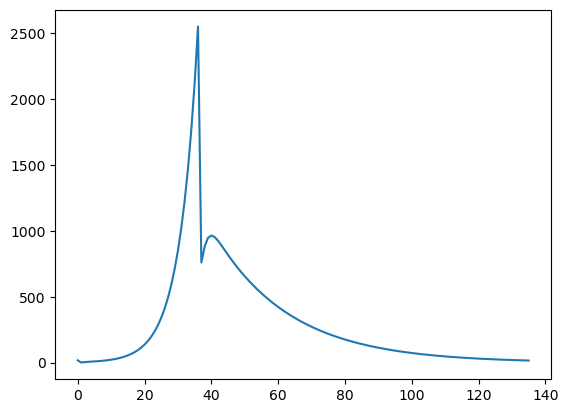

In [375]:
plt.plot(I_sim)

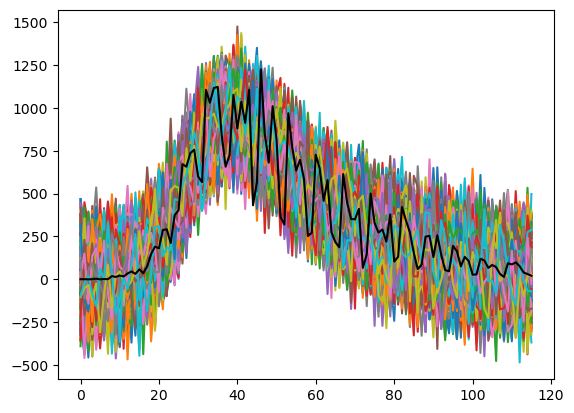

In [376]:
plt.plot(Ys_sim.T)
plt.plot(Y_data, color='black')
plt.show()

## plots

In [33]:
id_valid = (ssim_eps[:,0] - ssim_eps[:,-1] > 0)

(array([  5.,  15.,  64., 137., 257., 244., 155.,  88.,  28.,   7.]),
 array([104.80967321, 110.81766379, 116.82565437, 122.83364494,
        128.84163552, 134.8496261 , 140.85761668, 146.86560726,
        152.87359783, 158.88158841, 164.88957899]),
 <BarContainer object of 10 artists>)

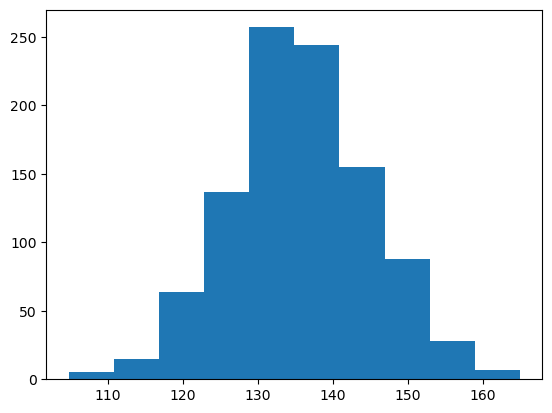

In [34]:
plt.hist(ssim_eps[id_valid,-1])

(array([393., 300., 164.,  69.,  35.,  23.,   9.,   3.,   2.,   2.]),
 array([1.32423522e-01, 1.40603365e+01, 2.79882495e+01, 4.19161624e+01,
        5.58440754e+01, 6.97719884e+01, 8.36999014e+01, 9.76278143e+01,
        1.11555727e+02, 1.25483640e+02, 1.39411553e+02]),
 <BarContainer object of 10 artists>)

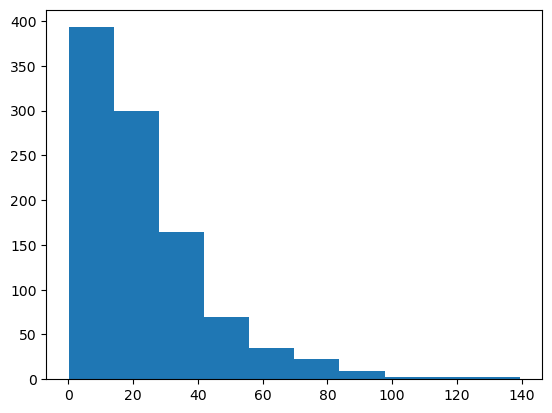

In [35]:
plt.hist(msim_0[id_valid,-1])

Text(0, 0.5, '$\\hat{\\beta}_1$')

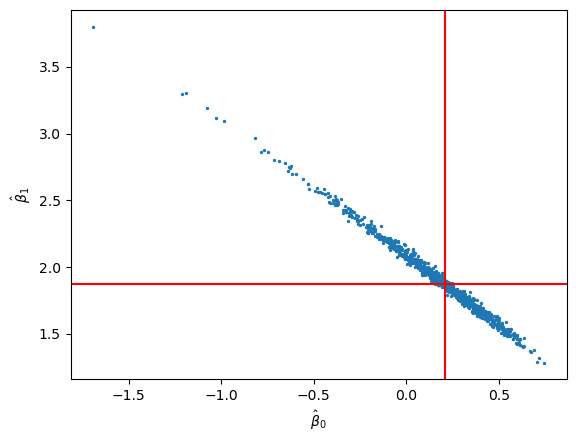

In [36]:
plt.scatter(bsim[id_valid,-1,0],bsim[id_valid,-1,1], s=2)
plt.axhline(y=beta[1], color='red')
plt.axvline(x=beta[0], color='red')
plt.xlabel(r"$\hat{\beta}_0$"); plt.ylabel(r"$\hat{\beta}_1$")

(array([ 57., 325., 353., 173.,  60.,  20.,   6.,   3.,   2.,   1.]),
 array([1.2826411 , 1.53444442, 1.78624775, 2.03805107, 2.2898544 ,
        2.54165772, 2.79346105, 3.04526438, 3.2970677 , 3.54887103,
        3.80067435]),
 <BarContainer object of 10 artists>)

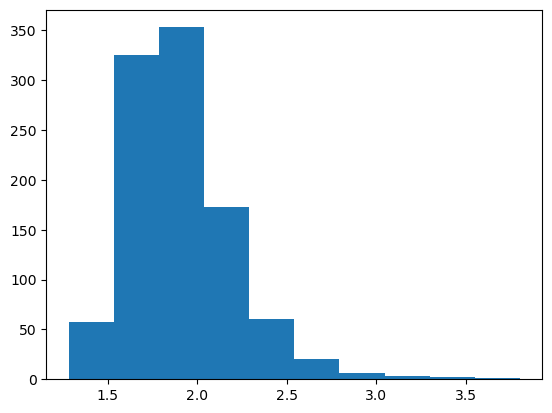

In [37]:
plt.hist(bsim[id_valid,-1,1])

In [38]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[0,0])

0.27909071626398185

In [39]:
np.sqrt(np.cov(bsim[id_valid,-1,:].T)[1,1])

0.291510832277994

In [40]:
np.cov(bsim[id_valid,-1,:].T)

array([[ 0.07789163, -0.08105295],
       [-0.08105295,  0.08497857]])

In [41]:
Rsim = np.zeros([T+T0,np.sum(id_valid)])
for t in np.arange(T+T0):
    Rsim[t] = K / (1 + np.exp(bsim[id_valid,-1,:] @ A[t]))

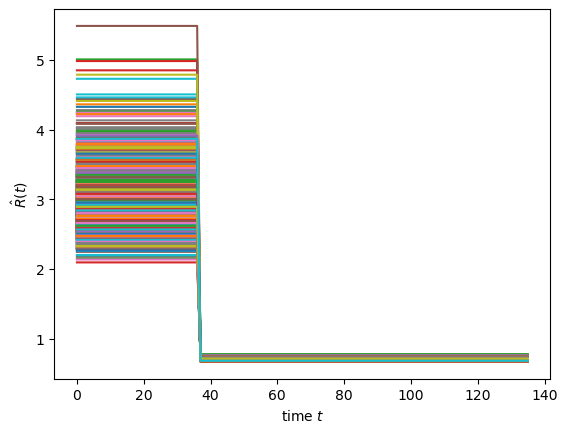

In [42]:
plt.plot(Rsim)
plt.xlabel(r"time $t$"); plt.ylabel(r"$\hat{R}(t)$")
plt.show()

# save and load

In [72]:
# np.savez("result_parametric_zero_s_eta.npz",
#          mmle_0 = mmle_0, smle_eps = smle_eps, bmle = bmle,
#          mhs_0 = mhs_0, shs_eps = shs_eps, bhs = bhs,
#          msim_0 = msim_0, ssim_eps = ssim_eps, bsim = bsim,
#          I_sim = I_sim, Ys_sim = Ys_sim, g = g, pi = pi, A = A)

In [32]:
locals().update(np.load("result_parametric_zero_s_eta.npz"))